In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

In [2]:
path = 'fmt.all'
starting_day = '2018-11-06'
frequency = 27e6

In [3]:
def load_data(path, starting_day, frequency):
    with open(path) as f:
        data = [(s.split()[0], float(s.split()[5])) for s in f.readlines()]
    timestamps = np.array([np.datetime64(starting_day + 'T' + d[0]) for d in data])
    # correct rollover
    timestamps += np.concatenate(([0], np.cumsum(np.diff(np.array(timestamps)) < np.timedelta64(0)))) * np.timedelta64(3600*24)
    ppb = [-d[1]/frequency*1e9 for d in data]
    data = xr.DataArray(ppb, coords = {'time':timestamps}, dims = ('time'))
    data.attrs['units'] = 'ppb'
    data.name = 'Frequency offset'
    return data

In [4]:
ppb = load_data(path, starting_day, frequency)
ppb = ppb[ppb > -720][:-1] # filter some invalid measurements

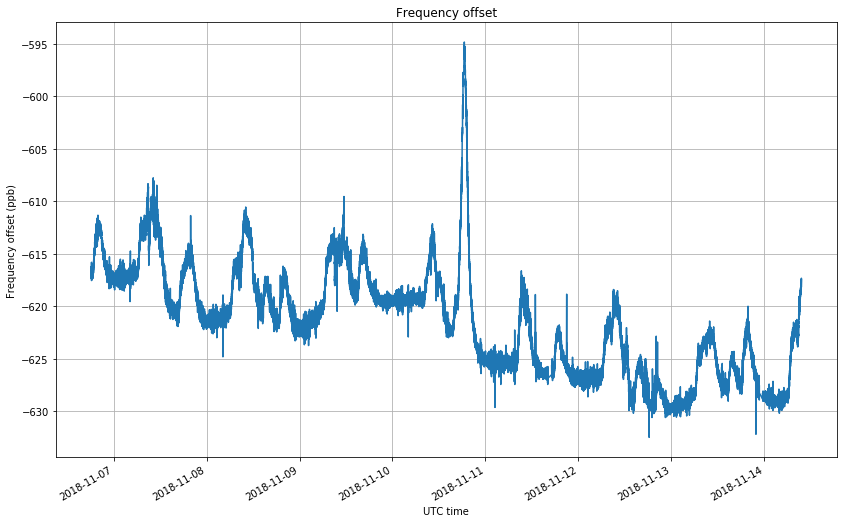

In [5]:
plt.figure(figsize=(14,8))
ppb.plot()
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid()
plt.title('Frequency offset')
plt.xlabel('UTC time')
plt.ylabel('Frequency offset (ppb)');

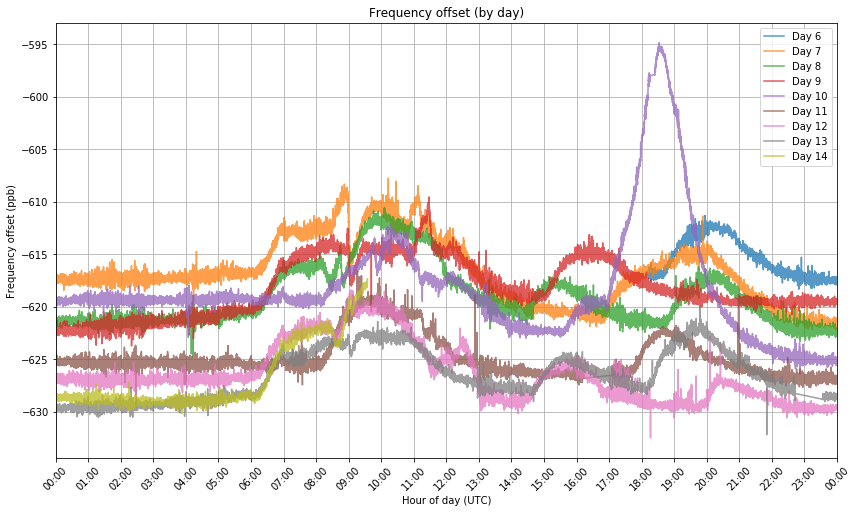

In [6]:
plt.figure(figsize=(14,8))
for g in ppb.groupby('time.day'):
    plt.plot(np.datetime64('2000-01-01') + (g[1].coords['time'] - g[1].coords['time'].astype('datetime64[D]')), g[1],\
             label = f'Day {g[0]}', alpha = 0.75)
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlim(['2000-01-01T00:00', '2000-01-02T00:00'])
plt.legend()
plt.grid()
plt.title('Frequency offset (by day)')
plt.xlabel('Hour of day (UTC)')
plt.ylabel('Frequency offset (ppb)');

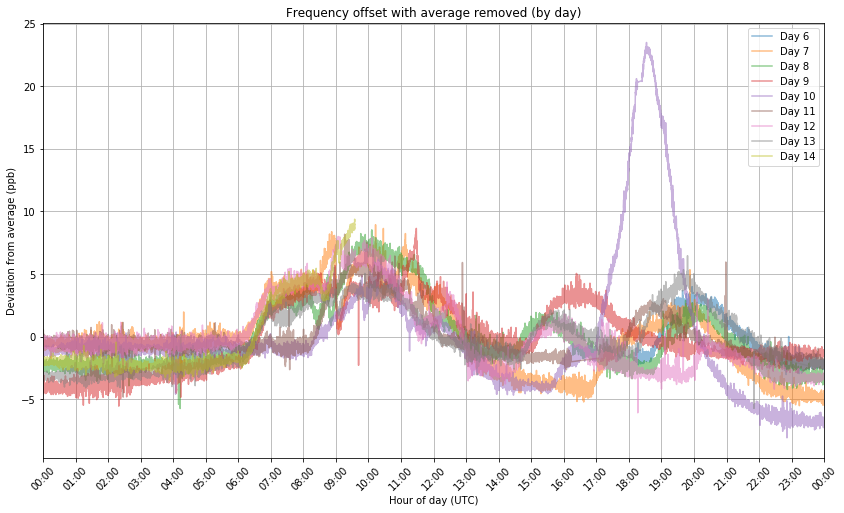

In [7]:
plt.figure(figsize=(14,8))
for g in ppb.groupby('time.day'):
    plt.plot(np.datetime64('2000-01-01') + (g[1].coords['time'] - g[1].coords['time'].astype('datetime64[D]')), g[1] - g[1].mean(),\
             label = f'Day {g[0]}', alpha = 0.5)
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlim(['2000-01-01T00:00', '2000-01-02T00:00'])
plt.legend()
plt.grid()
plt.title('Frequency offset with average removed (by day)')
plt.xlabel('Hour of day (UTC)')
plt.ylabel('Deviation from average (ppb)');

In [8]:
def avar(x, tau):
    return 1e-9*np.sqrt(0.5*(x.resample(time=f'{int(round(tau))}S').mean().diff('time')**2).mean())

In [9]:
taus = np.logspace(1,5)
avars = [avar(ppb, tau) for tau in taus]

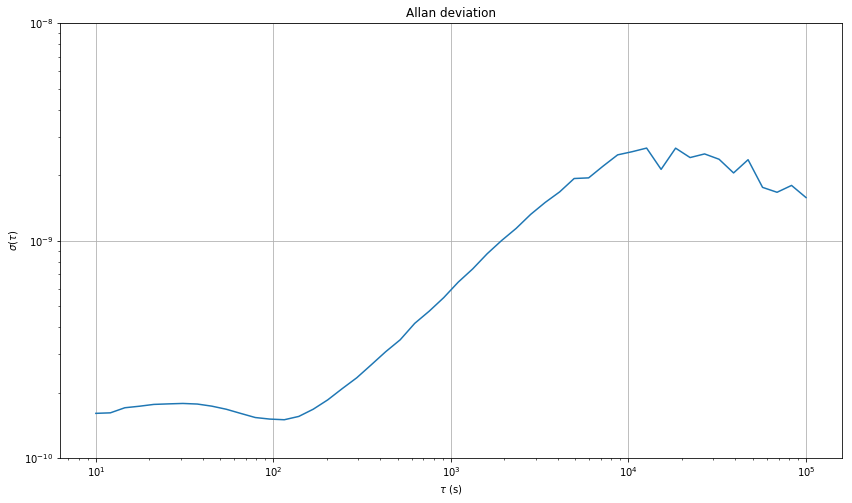

In [10]:
plt.figure(figsize=(14,8))
plt.loglog(taus, avars)
plt.grid()
plt.title('Allan deviation')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$');
plt.ylim([1e-10,1e-8]);